In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'../')

# Notebook: Vertical dynamical equilibrium and SFR surface density

In [3]:
import matplotlib.pyplot as plt
import prfm

## Model

We set up a simple galaxy model between R=2-16kpc. The gas and stellar surface densities are decreasing linearly and exponetially with radius, respectively. The stellar scale height is held fixed. A flat rotation curve is assumed so that $\Omega_d\propto R^{-1}$. 

**The parameters must be in c.g.s. units.**

In [4]:
import astropy.constants as ac
import astropy.units as au
import numpy as np

# setting up some convenient conversion factors
surf_cgs = (ac.M_sun/ac.pc**2).cgs.value
sfr_cgs = (ac.M_sun/ac.kpc**2/au.yr).cgs.value
kms_cgs = (1*au.km/au.s).cgs.value

# default parameters
Sigma_gas = 10*ac.M_sun/ac.pc**2
Sigma_star = 42*ac.M_sun/ac.pc**2 
Omega_d = 28*au.km/au.s/ac.kpc
H_star = 245*ac.pc

R = np.linspace(2,16,50)*ac.kpc
R0 = 8*ac.kpc
Re = 3.5*ac.kpc

# in cgs
Sigma_gas = Sigma_gas.cgs.value
Sigma_star = Sigma_star.cgs.value
Omega_d = Omega_d.cgs.value
H_star = H_star.cgs.value
r0 = (R/R0).cgs.value
re = (R/Re).cgs.value

# to array
Sigma_gas = Sigma_gas/r0 # linear in R
Sigma_star = Sigma_star*np.exp((R0/Re).cgs.value-re)
Omega_d = Omega_d/r0 # flat rotation
H_star = H_star # no flaring
args = (Sigma_gas, Sigma_star, Omega_d, H_star, 15.e5)

# default keywords
kwargs = dict(zeta_d=1/3.)

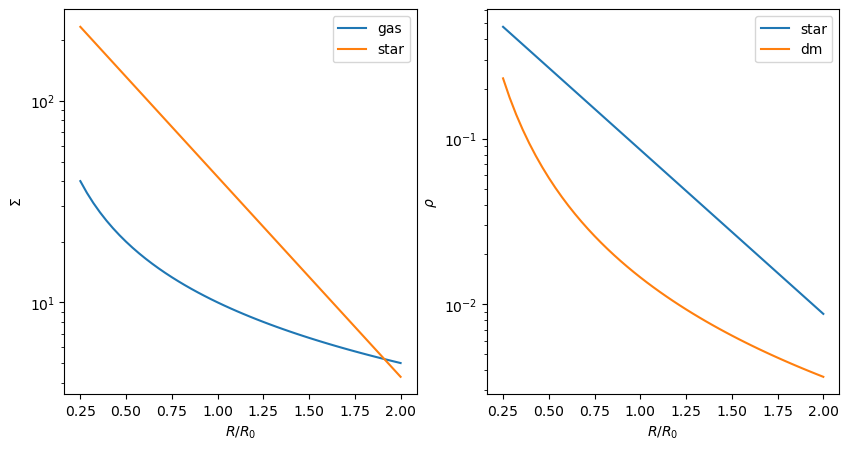

In [5]:
# model profiles
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(r0, Sigma_gas/surf_cgs,label='gas')
plt.plot(r0, Sigma_star/surf_cgs,label='star')
plt.ylabel(r'$\Sigma$')
plt.xlabel(r'$R/R_0$')
plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.plot(r0, Sigma_star/surf_cgs/(2*H_star/ac.pc.cgs.value),label='star')
plt.plot(r0, (Omega_d**2/4/np.pi/ac.G.cgs.value)/surf_cgs*ac.pc.cgs.value,label='dm')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$R/R_0$')
plt.legend()
plt.yscale('log')


## Test vertical equilibrium solutions

The gas scale heights can be calculated either anlytically or numerically. `gas_scale_height` provides a convenient wrapper for either case simply call different function depending on `method=["analytic", "numerical"]`. Internally, functions below will be called.

* `gas_scale_height_analytic` provides an anlytic solution of the cubic equation for a given parameter set.
    * `gas_scale_height_[gas,star,dm]_only` provides an anlytic solution when only weight from the selected component is considered.
    * `gas_scale_height_star_gas` provides an anlytic solution when dark matter contribution is neglected.
    * `gas_scale_height_dm_gas` provides an anlytic solution when stellar contribution is neglected.
* `gas_scale_height_numerical` provides a numerical solution for a given parameter set. Each weight term can be turned on and off by setting e.g., `wgas=1` or `wgas=0`.

Below, we assume a constant `sigma_eff` and show validity of different functions. 

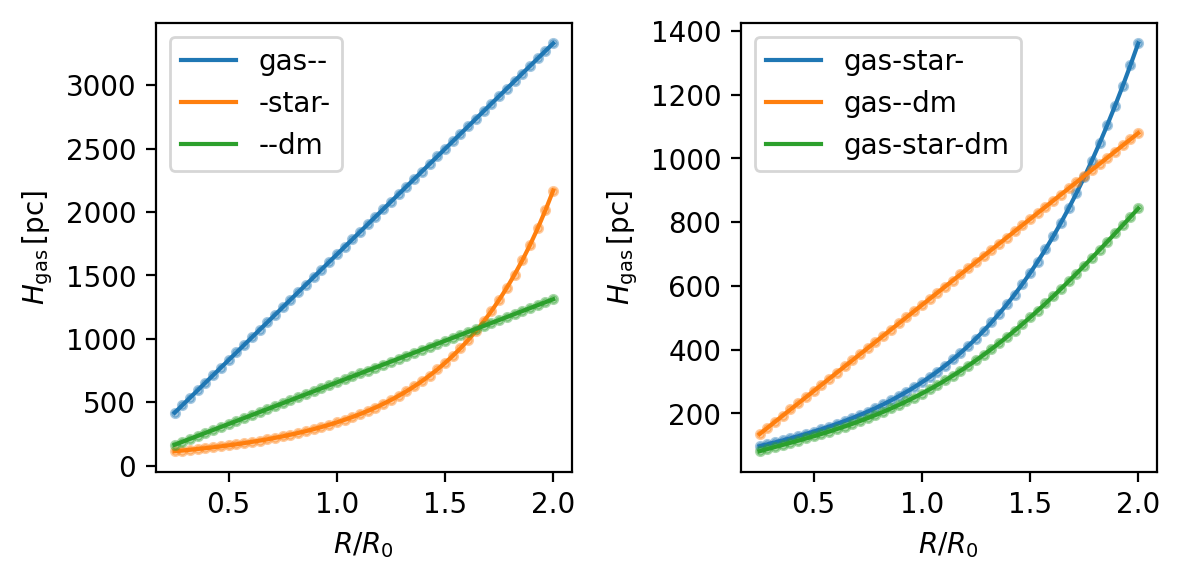

In [6]:
plt.rcParams['figure.dpi']=200
# sanity checks
fig, axes = plt.subplots(1,2, figsize=(6,3))

labels = ['gas', 'star', 'dm']
# gas, star, dm only scale heights
plt.sca(axes[0])
for w in [[1,0,0],[0,1,0],[0,0,1]]:
  H_ana=prfm.get_scale_height(*args,**kwargs,method='analytic',wgas=w[0],wstar=w[1],wdm=w[2])
  H_num=prfm.get_scale_height(*args,**kwargs,method='numerical',wgas=w[0],wstar=w[1],wdm=w[2])
  label = '-'.join([l if w_==1 else '' for w_,l in zip(w,labels)])
  l,=plt.plot(r0,H_ana/ac.pc.cgs.value,label = label)
  plt.plot(r0,H_num/ac.pc.cgs.value,'.',color=l.get_color(),alpha=0.4)
plt.ylabel(r'$H_{\rm gas}\,[{\rm pc}]$')
plt.xlabel(r'$R/R_0$')
plt.legend()

# star-gas, dm-gas, and full scale heights
plt.sca(axes[1])
for w in [[1,1,0],[1,0,1],[1,1,1]]:
  # H_ana=func(*args,**kwargs)
  # H_num = get_scale_height_numerical(*args,**kwargs,wgas=w[0],wstar=w[1],wdm=w[2])
  H_ana=prfm.get_scale_height(*args,**kwargs,method='analytic',wgas=w[0],wstar=w[1],wdm=w[2])
  H_num=prfm.get_scale_height(*args,**kwargs,method='numerical',wgas=w[0],wstar=w[1],wdm=w[2])
  label='-'.join([l if w_==1 else '' for w_,l in zip(w,labels)])

  l,=plt.plot(r0,H_ana/ac.pc.cgs.value, label = label)
  plt.plot(r0,H_num/ac.pc.cgs.value,'.',color=l.get_color(),alpha=0.4)
plt.ylabel(r'$H_{\rm gas}\,[{\rm pc}]$')
plt.xlabel(r'$R/R_0$')
plt.legend()
plt.tight_layout()

There are additional convenient function wrappers (internally using `get_scale_height` to find gas scale height):
* `get_weights`: returns $H_{\rm gas}$, $\cal{W}_{\rm gas}$, $\cal{W}_*$, and $\cal{W}_{\rm dm}$
* `get_weight_contribution`: returns $\cal{W}_{\rm gas}/\cal{W}_{\rm tot}$, $\cal{W}_*/\cal{W}_{\rm tot}$, and $\cal{W}_{\rm dm}/\cal{W}_{\rm tot}$ 

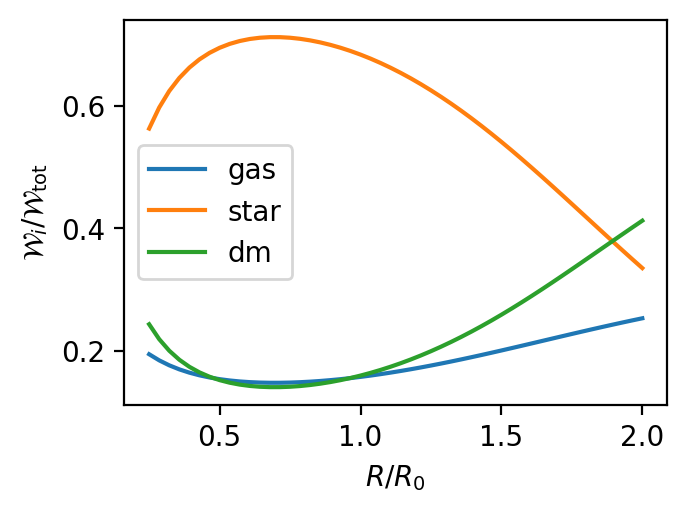

In [7]:
wfrac=prfm.get_weight_contribution(*args,**kwargs)
plt.figure(figsize=(3.5,2.5))
plt.plot(r0,wfrac[0],label='gas')
plt.plot(r0,wfrac[1],label='star')
plt.plot(r0,wfrac[2],label='dm')
plt.ylabel(r'$\mathcal{W}_i/\mathcal{W}_{\rm tot}$')
plt.xlabel(r'$R/R_0$')
plt.legend()


## Self-consistent solutions for different velocity dispersion models

`get_self_consistent_solution` function will calculate the scale height, weight, and velocity dispersion iteratively for a given velocity dispersion model. 

`sigma_eff` can either be a constant or a string to specify a model. For now, we provide two velocity dispersion models `tigress_mid` and `tigress_avg`. Additional calibration results will be updated. For user-specfic velocity dispersion models using the same functional form, one can specify coefficient, `sigma_0`, and power-law exponent, `expo`, as well as the minimum veloicty dispersion, `sigma_min`.

```python
sigma_eff_models['custom']=dict(sigma_0 = 10, expo = 0.2, sigma_min=10)
```

Then, `sigma_eff="custom"` can be passed as a keyword for  the function `get_self_consistent_solution`

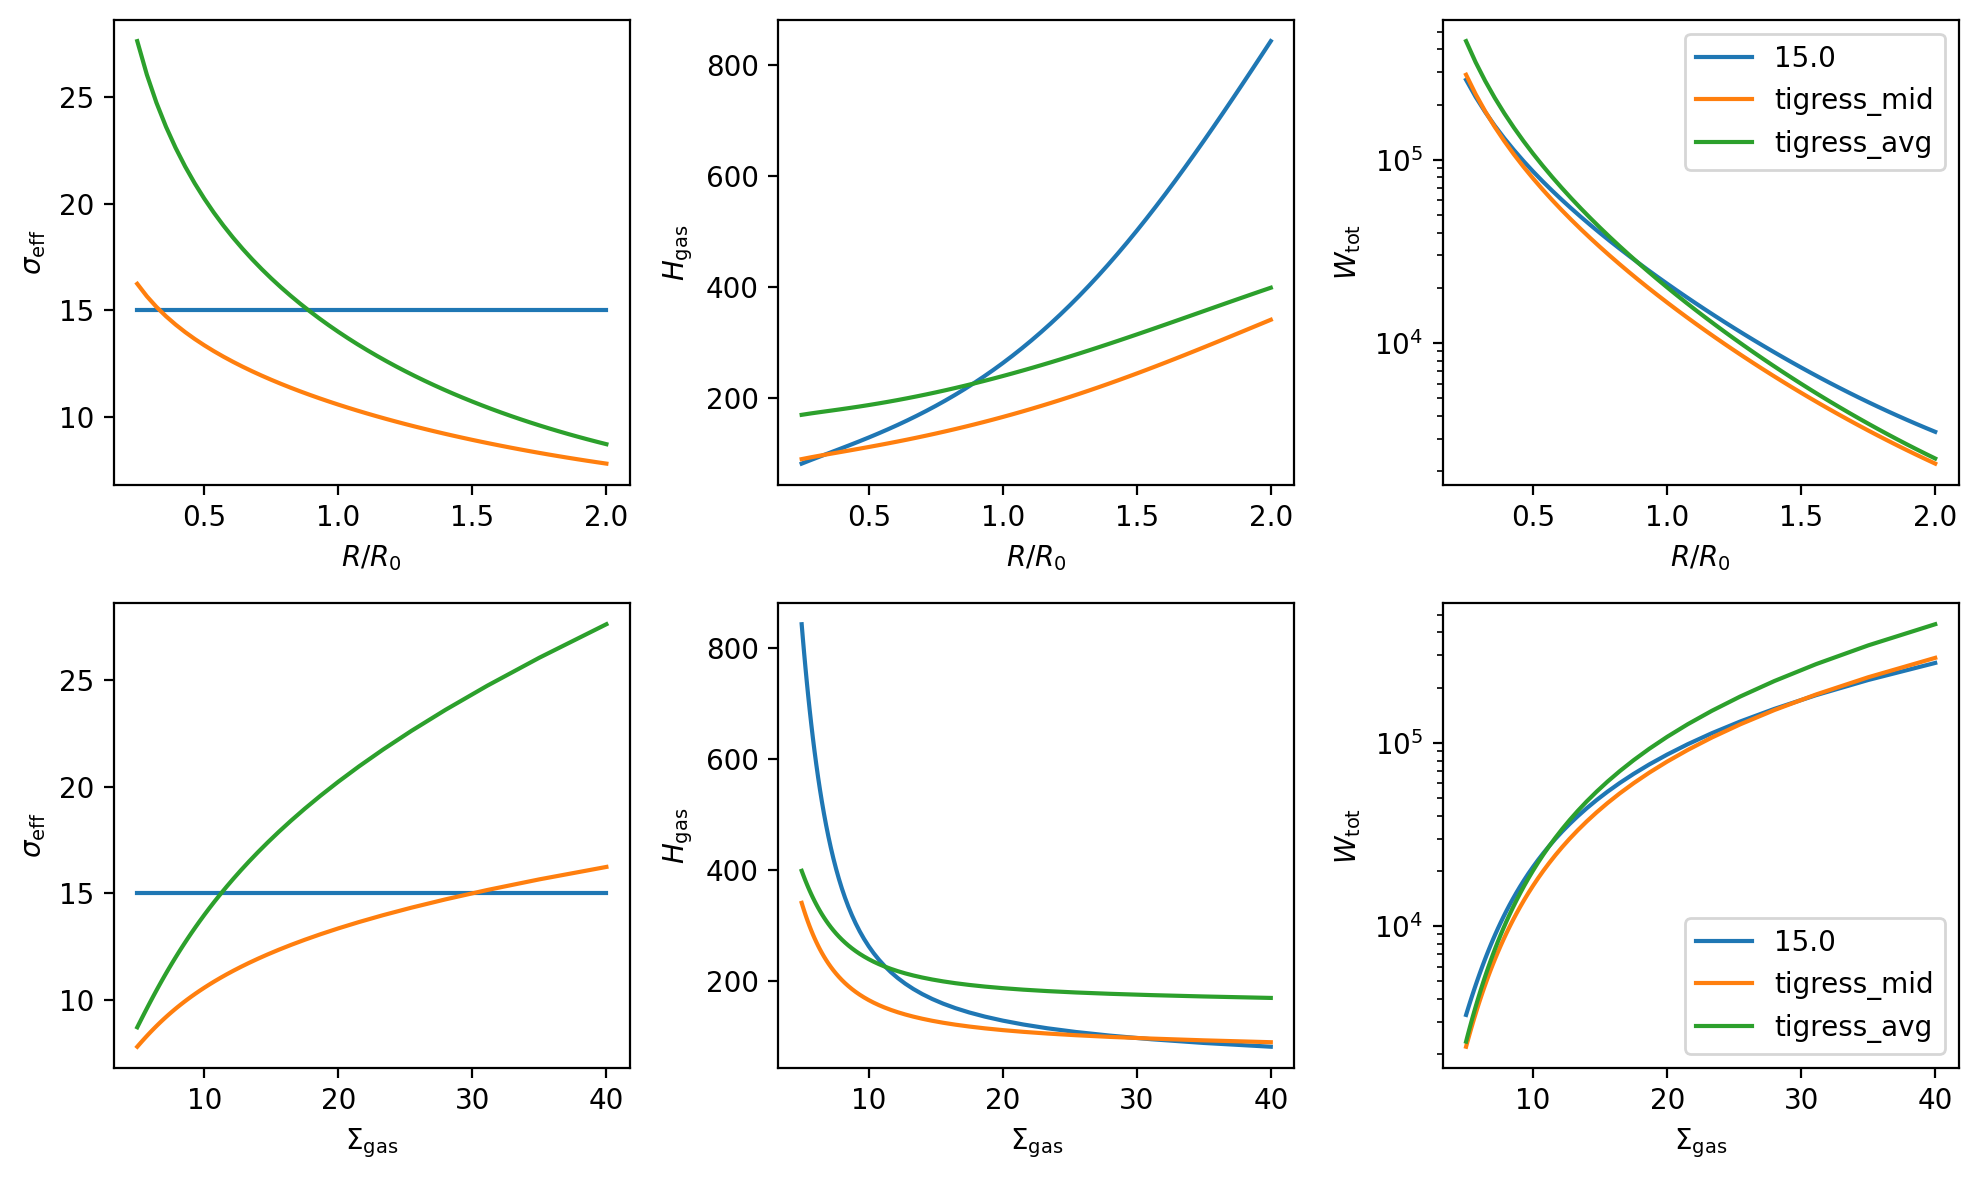

In [8]:
fig,axes_ = plt.subplots(2, 3, figsize=(10,6))
axes = axes_[0,:]
for sigma in [15.e5, 'tigress_mid', 'tigress_avg']:
    args = (Sigma_gas, Sigma_star, Omega_d, H_star, sigma)
    Wtot, H, seff = prfm.get_self_consistent_solution(*args, method='numerical')
    label='{}'.format(sigma if type(sigma) == str else sigma/1.e5)
    for y,ax in zip([seff/kms_cgs, H/ac.pc.cgs.value, Wtot/ac.k_B.cgs.value],axes):
        plt.sca(ax)
        plt.plot(r0, y, label=label)
xlab = r'$R/R_0$'
ylabels = [r'$\sigma_{\rm eff}$', r'$H_{\rm gas}$', r'$W_{\rm tot}$']
for ax, ylab in zip(axes,ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale('log')
# plt.xscale('log')
plt.legend()

axes = axes_[1,:]
for sigma in [15.e5, 'tigress_mid', 'tigress_avg']:
    args = (Sigma_gas, Sigma_star, Omega_d, H_star, sigma)
    Wtot, H, seff = prfm.get_self_consistent_solution(*args, method='analytic')
    label='{}'.format(sigma if type(sigma) == str else sigma/1.e5)
    for y,ax in zip([seff/kms_cgs, H/ac.pc.cgs.value, Wtot/ac.k_B.cgs.value],axes):
        plt.sca(ax)
        plt.plot(Sigma_gas/surf_cgs, y, label=label)
xlab = r'$\Sigma_{\rm gas}$'
ylabels = [r'$\sigma_{\rm eff}$', r'$H_{\rm gas}$', r'$W_{\rm tot}$']
for ax, ylab in zip(axes,ylabels):
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.tight_layout()

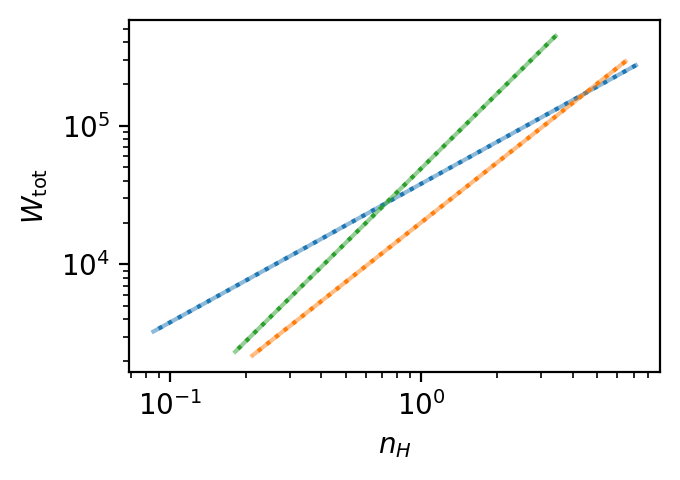

In [9]:
# sanity check for effective EOS
fig = plt.figure(figsize=(3.5,2.5))
ax = plt.subplot(111)
for sigma in [15.e5, 'tigress_mid', 'tigress_avg']:
    args = (Sigma_gas, Sigma_star, Omega_d, H_star, sigma)
    Wtot, H, seff = prfm.get_self_consistent_solution(*args, method='numerical',tol=1.e-5)
    rho = Sigma_gas/(2*H)
    nH = rho/(1.4*ac.m_p.cgs.value)
    label='{}'.format(sigma if type(sigma) == str else sigma/1.e5)

    l,=plt.plot(nH,Wtot/ac.k_B.cgs.value,alpha=0.5,label=label)
    seff = prfm.get_sigma_eff(Wtot,model=sigma) if type(sigma) == str else sigma
    plt.plot(nH,rho*seff**2/ac.k_B.cgs.value,color=l.get_color(),ls=':')

plt.sca(ax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n_H$')
plt.ylabel(r'$W_{\rm tot}$')
# plt.xscale('log')
plt.tight_layout()



## SFR surface density

Text(0, 0.5, '$\\Sigma_{\\rm SFR}\\, [M_\\odot\\,{\\rm kpc^{-2}\\,yr^{-1}}]$')

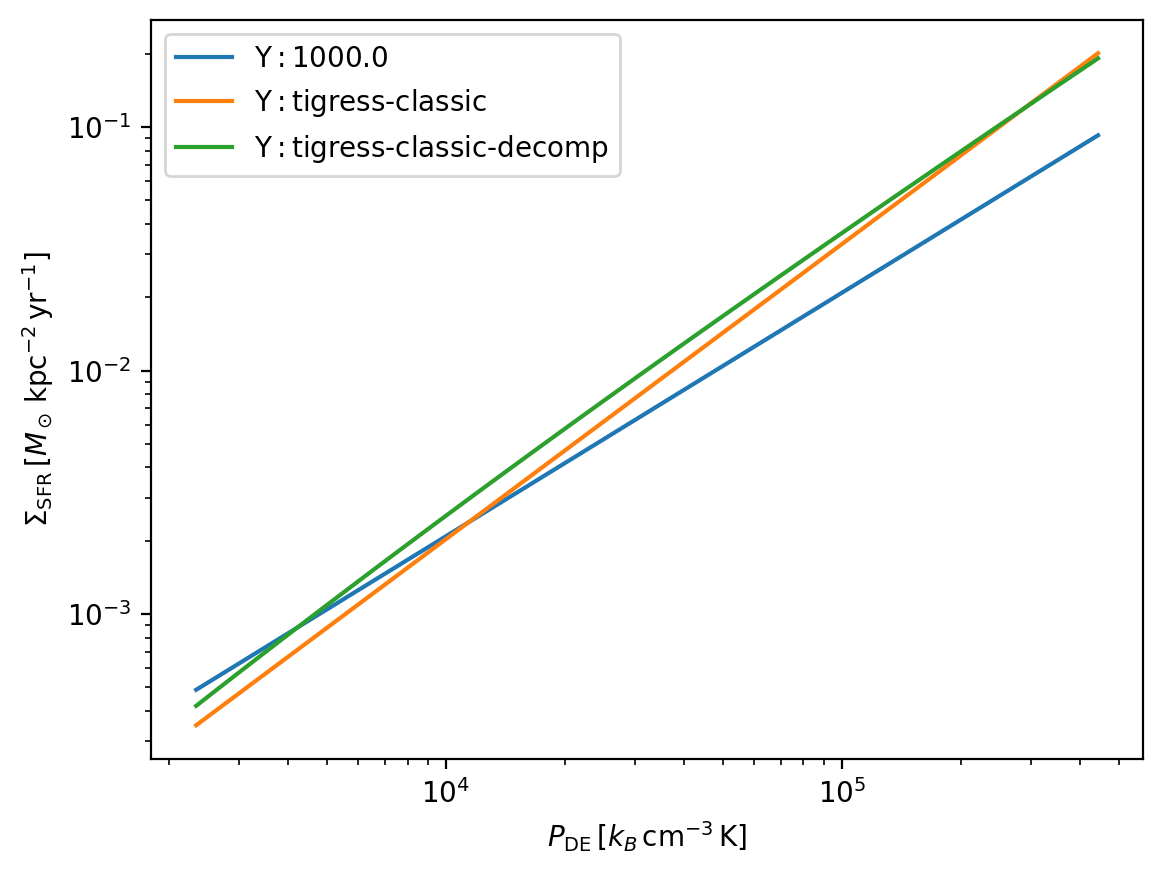

In [10]:
# Pressure-Sigma_SFR relation
for y in [1.e3,'tigress-classic','tigress-classic-decomp']:
    plt.plot(Wtot/ac.k_B.cgs.value,
             prfm.get_sfr(Wtot,Ytot=y)/sfr_cgs, 
             label=r'$\Upsilon:$' + '{}'.format(y))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$P_{\rm DE}\, [k_B{\rm\,cm^{-3}\,K}]$')
plt.ylabel(r'$\Sigma_{\rm SFR}\, [M_\odot\,{\rm kpc^{-2}\,yr^{-1}}]$')